# Exercise 5

In [22]:
# Done by Timo Marks
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import mnist
subplot_keywords = {"xticks": [0,27], "yticks": [0,27]}

## Function for:
## Task 2/3: Loading image data
## Task 4: Converting data matrix to feature vector, and normalization
## Task 5: Adding a row of dummy ones to the feature vector to avoid offset term

In [44]:
def MnistRead():
    train_images = mnist.train_images()
    train_labels = mnist.train_labels()

    test_images = mnist.test_images()
    test_labels = mnist.test_labels()

    print('train_images: ' + str(train_images.shape))
    print('train_labels: ' + str(train_labels.shape))
    print('test_images:  '  + str(test_images.shape))
    print('test_labels:  '  + str(test_labels.shape))
    return [train_images, train_labels, test_images, test_labels]

# Creates num_grid * num_grid subplot of images
def MnistShow(images, num_grid = 4):
    plt.set_cmap("gray")
    fig, ax = plt.subplots(num_grid, num_grid, figsize=(10,10), sharex=True, sharey=True, subplot_kw = subplot_keywords)
    for i in range(num_grid):
        for j in range(num_grid):
            ax[i,j].imshow(images[i*num_grid+j])
    plt.show()

# Create a feature vector of each image
# One Column = One picture = One feature vector
def matrix2vector(images):
    images = images.reshape(images.shape[0], (images.shape[1] * images.shape[2]))
    # This is wrong: See Note Nr. 1 at the end
    # images = images.reshape((images.shape[1] * images.shape[2]), images.shape[0]) 

    images = images.transpose()
    # Add dummy ones --> one column now 785 numbers
    images = np.vstack([np.ones(images.shape[1]), images])
    return images

# Inverse transformation of feature vector in image
def vector2matrix(feature_vector, NCol, NRow):
    # Remove dummy ones
    feature_vector = feature_vector[1:]
    feature_vector = feature_vector.transpose()
    return feature_vector.reshape(feature_vector.shape[0], NCol, NRow) # Original shape

# Normalization: Gray Value from 0 to 1
def normalize(images):
    return images/np.max(images)

# Array containing only the specific numbers
def masking_data(images, labels, digit):
    digit_mask = labels[0,:] == digit
    images_digit = images[digit_mask]
    digit_mask = np.expand_dims(digit_mask, axis=0)
    labels_digit = labels[digit_mask]

    return [images_digit, labels_digit]

### 1. Read in Data and Visualization

In [24]:
[train_images, train_labels, test_images, test_labels] = MnistRead()
train_images = normalize(train_images)
test_images = normalize(test_images)

# Pick out specific numbers
digit_A = 1
digit_B = 4

# Array containing both numbers
train_labels_mask = np.asarray(train_labels[:] == digit_A) | (train_labels[:] == digit_B)
train_images, train_labels = train_images[train_labels_mask,:,:], train_labels[train_labels_mask]

test_labels_mask = np.asarray(test_labels[:] == digit_A) | (test_labels[:] == digit_B)
test_images, test_labels = test_images[test_labels_mask,:,:], test_labels[test_labels_mask]

# Explaination: train_labels.shape is (x,)
# When we will use matrix multiplication with dimensions like: (1,x) * (x,1) = scalarproduct
# We cannot use the (x,) vectors and (x,).tranpose yields to (x,)
# Therefore expand dimensions explicitly to (x,1) 
# In numpy (x,) is the vector (or more like a list) and (x,1) a matrix

train_labels = np.expand_dims(train_labels, axis=0)
test_labels = np.expand_dims(test_labels, axis=0)

[train_images_digit_A, train_labels_digit_A] = masking_data(train_images, train_labels, digit_A)
[train_images_digit_B, train_labels_digit_B] = masking_data(train_images, train_labels, digit_B)
[test_images_digit_A, test_labels_digit_A] = masking_data(test_images, test_labels, digit_A)
[test_images_digit_B, test_labels_digit_B] = masking_data(test_images, test_labels, digit_B)



# # # Array containing only the specific numbers 
# train_digit_A_mask = train_labels[0,:] == digit_A
# train_images_digit_A = train_images[train_digit_A_mask]
# train_digit_A_mask = np.expand_dims(train_digit_A_mask, axis=0)
# train_labels_digit_A = train_labels[train_digit_A_mask]

# train_digit_B_mask = train_labels[0,:] == digit_B
# train_images_digit_B = train_images[train_digit_B_mask]
# train_digit_B_mask = np.expand_dims(train_digit_B_mask, axis=0)
# train_labels_digit_B = train_labels[train_digit_B_mask]

# test_digit_A_mask = test_labels[0,:] == digit_A
# test_images_digit_A = test_images[test_digit_A_mask]
# test_digit_A_mask = np.expand_dims(test_digit_A_mask, axis=0)
# test_labels_digit_A = test_labels[test_digit_A_mask]

# test_digit_B_mask = test_labels[0,:] == digit_B
# test_images_digit_B = test_images[test_digit_B_mask]
# test_digit_B_mask = np.expand_dims(test_digit_B_mask, axis=0)
# test_labels_digit_B = test_labels[test_digit_B_mask]



train_images: (60000, 28, 28)
train_labels: (60000,)
test_images:  (10000, 28, 28)
test_labels:  (10000,)


<Figure size 432x288 with 0 Axes>

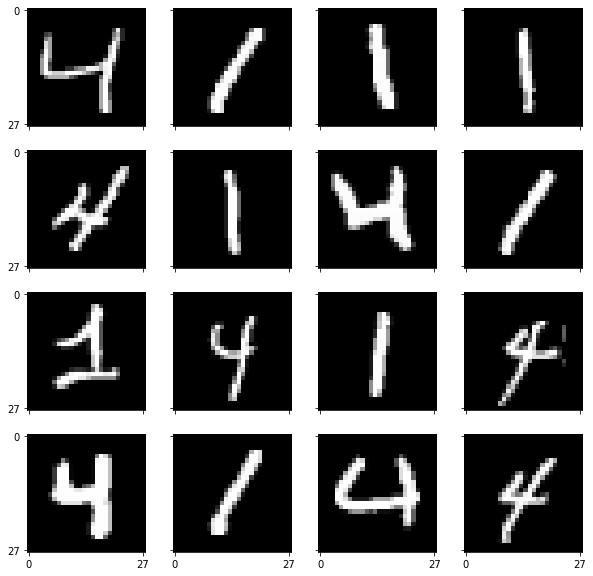

<Figure size 432x288 with 0 Axes>

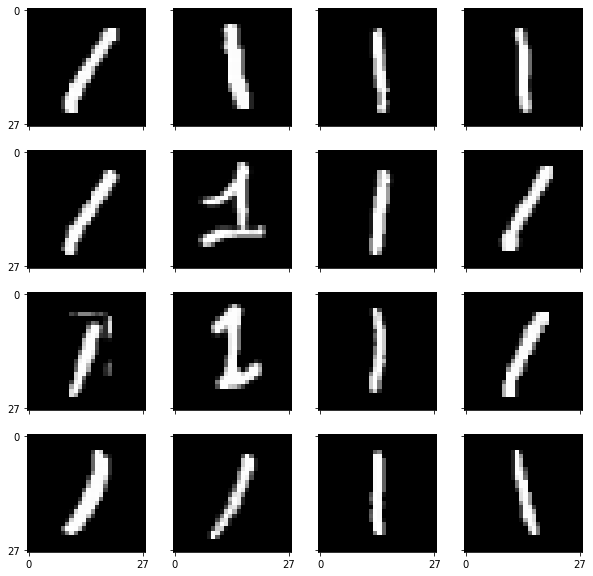

In [25]:
MnistShow(train_images) # Both digits
MnistShow(train_images_digit_A) # Only Digit B

## Task 4 Converting data matrix to feature vector: Test Images
If this fails, the upcoming calculation are not correct. Make sure the images are the same

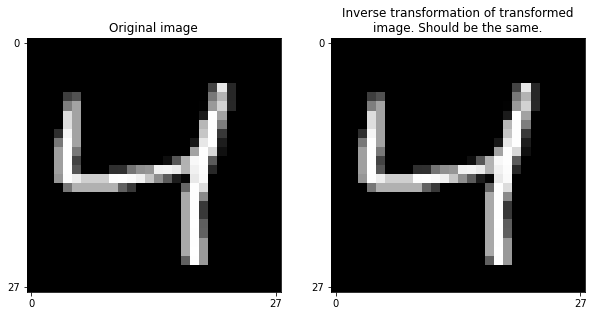

In [35]:
(NFrame, NRow, NCol) = train_images.shape
feature_vectors = matrix2vector(train_images)
images = vector2matrix(feature_vectors, NRow, NCol)

fig, ax = plt.subplots(1,2, figsize=(10,5), subplot_kw=subplot_keywords)
ax[0].imshow(train_images[0])
ax[1].imshow(images[0])
ax[0].set_title("Original image")
ax[1].set_title("Inverse transformation of transformed\nimage. Should be the same.")
plt.plot();

### Task 6: Perform Logistic Regression Gradient

In [36]:
def gradient_descent_logreg(max_iter, step_size, vec_w_init, mat_X, mat_X_digits, weights_filename = "vec_w_opt_logreg", vec_y_filename = "vec_y_logreg"):
    # Number Samples = Number Columns
    N = mat_X.shape[1]
    # Convert the vector of true label mat_X_digits to binary num(0,1) <-> digit(A, B)
    vec_y = map_digit_to_vec_y(mat_X_digits)
    vec_L = []

    for i in np.arange(max_iter):
        # Estimation of y --> y hat
        y_estimate = vec_y_estimate(vec_w_init, mat_X) # shape = (1,N)

        # Cross entropy loss function
        L = -1/N * np.sum(vec_y*np.log(y_estimate)+(1-vec_y)*np.log(1-y_estimate)) # scalar
        vec_L.append(L)

        # Gradient Descent Algorithm
        grad_L= 1/N * np.matmul(mat_X,(y_estimate-vec_y).transpose())
        vec_w_init = vec_w_init - step_size * grad_L
        ### Explanation
        # For the gradient of L(w) I rewrote the sum
        # We have the shapes: (y_estimate-vec_y).shape=(1, N)
        #                     mat_X.shape=(785, N)
        # The sum says, take entry i of (y_estimate-vec_y) and multiply it with vector mat_X[i]
        # which is one whole column. This is the same as mat_X * (y_estimate-vec_y).transpose() and in shapes
        # (785, N) * (N, 1) = (785,1)
        # So the summation over all N samples is hidden in the matrix multiplication for each row in mat_X

    return (vec_L, vec_w_init)

def vec_y_estimate(vec_w_init, mat_X):
    exp_argument = np.matmul(vec_w_init.transpose(), mat_X) # shape = (1,N)
    return 1.0/(1+np.exp(-exp_argument)) # shape = (1,N)

def map_digit_to_vec_y(mat_X_digits):
    vec_y = np.zeros((1,mat_X_digits.shape[1])) # digit A entries to 0
    digit_B_mask = mat_X_digits[0,:] == digit_B
    digit_B_mask = np.expand_dims(digit_B_mask,axis=0)  # Shape (1,N)
    vec_y[digit_B_mask] = 1  # digit B entries to 1
    return vec_y
    

def compute_output_vec_y (vec_w_opt_lda, mat_X):
    return np.matmul(np.transpose(vec_w_opt_lda), mat_X)

def predict_one_y (vec_w_opt_lda, x, digit_A, digit_B):
    vec_y_lda = compute_output_vec_y(vec_w_opt_lda, x)
    if vec_y_lda > 0: 
        return digit_A
    else:
        return digit_B

In [45]:
mat_X_digits = train_labels
vec_y = np.zeros((1, mat_X_digits.shape[1])) 
digit_B_mask = mat_X_digits[0,:] == digit_B
digit_B_mask = np.expand_dims(digit_B_mask,axis=0)  #(1,N)
vec_y[digit_B_mask] = 1

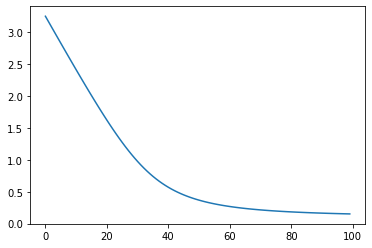

In [47]:
mat_X = matrix2vector(train_images)
mat_X_digits = train_labels
vec_L = []
vec_y = map_digit_to_vec_y(mat_X_digits)
N = mat_X.shape[1]
vec_w_init = np.zeros((NRow*NCol+1,1))+0.1
exp_argument = np.matmul(vec_w_init.transpose(), mat_X) # shape = (1,N)
y_estimate = 1.0/(1+np.exp(-np.matmul(vec_w_init.transpose(), mat_X))) # shape = (1,N)
L = -1.0/N * np.sum(vec_y*np.log(y_estimate)+(1-vec_y)*np.log(1-y_estimate))

# For the gradient of L(w) I rewrote the sum
# We have the shapes: (y_estimate-vec_y).shape=(1, N)
#                     mat_X.shape=(785, N)
# The sum says, take entry i of (y_estimate-vec_y) and multiply it with vector mat_X[i]
# which is one whole column. This is the same as mat_X * (y_estimate-vec_y).transpose() and in shapes
# (785, N) * (N, 1) = (785,1)
# So the summation is hidden in the matrix multiplication for each row in mat_X


grad_L_sum = np.matmul(mat_X,(y_estimate-vec_y).transpose())
grad_L = 1/N * grad_L_sum

# The same
grad_L_2 = 1/N * (y_estimate[0,0]-vec_y[0,0])*mat_X[:,0]
for i in np.arange(N-1):
    grad_L_2 += 1/N * (y_estimate[0,i+1]-vec_y[0,i+1])*mat_X[:,i+1]

max_iter = 100
step_size = 0.01
for i in np.arange(max_iter):
    y_estimate = 1.0/(1+np.exp(-np.matmul(vec_w_init.transpose(), mat_X))) # shape = (1,N)
    L = -1/N * np.sum(vec_y*np.log(y_estimate)+(1-vec_y)*np.log(1-y_estimate))
    vec_L.append(L)
    grad_L= 1/N * np.matmul(mat_X,(y_estimate-vec_y).transpose())
    vec_w_init = vec_w_init - step_size * grad_L


plt.plot(vec_L)

Text(0, 0.5, 'Cross-Entropy loss function L')

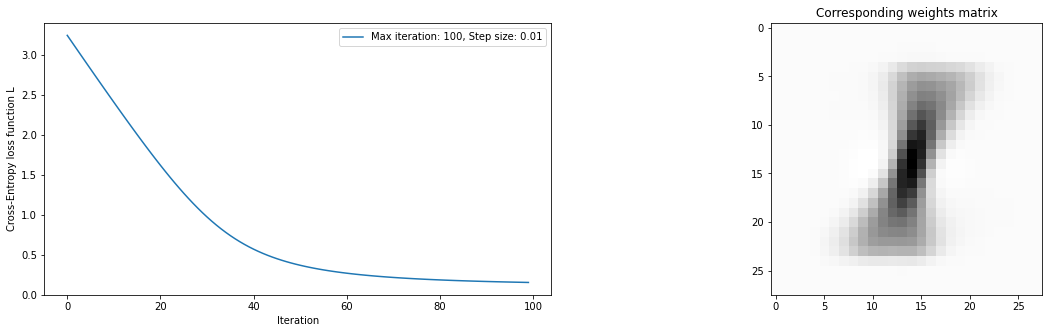

In [52]:
(NFrame, NRow, NCol) = train_images.shape
train_images_feature_vec = matrix2vector(train_images)
vec_w_init = np.zeros((NRow*NCol+1,1))+0.1

max_iter = 100
step_size = 0.01
(vec_L, optimal_w_vec) = gradient_descent_logreg(max_iter, step_size, vec_w_init, train_images_feature_vec, train_labels)
optimal_w_mat = vector2matrix(optimal_w_vec, NRow, NCol)

# Plot Results
fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].plot(vec_L, label=f"Max iteration: {max_iter}, Step size: {step_size}")
ax[1].imshow(optimal_w_mat[0])

ax[0].legend()
ax[1].set_title("Corresponding weights matrix")

ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("Cross-Entropy loss function L")

### 6 Model Accuracy
The method gives a high accuracy around 97%-99% even when the test data set is used. The Accuracy depends on the used numbers. Numbers which are more similar have a smaller pair accuracy. 

In [49]:
def compute_accuracy(vec_y_lda, vec_y_true, digit_A, digit_B):
    vec = (np.zeros(vec_y_lda.shape[1]))
    vec_y_lda = vec_y_lda.flatten()
    vec[vec_y_lda[:] > 0] = digit_A
    vec[vec_y_lda[:] <= 0] = digit_B
    vec_true_false = vec[vec == vec_y_true]

    return len(vec_true_false)/len(vec_y_true)

In [50]:
vec_y_lda = compute_output_vec_y(vec_w_opt_lda, matrix2vector(train_images))
accuracy = compute_accuracy(vec_y_lda, train_labels, digit_A, digit_B)
print(f"Train data: The Accuracy of the model with digit A: {digit_A} and digit B: {digit_B} is: {accuracy:.5f}")

vec_y_lda = compute_output_vec_y(vec_w_opt_lda, matrix2vector(test_images))
accuracy = compute_accuracy(vec_y_lda, test_labels, digit_A, digit_B)
print(f"Test data:  The Accuracy of the model with digit A: {digit_A} and digit B: {digit_B} is: {accuracy:.5f}")

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 785 is different from 784)

### 7. Test model with test dataset and show the classification

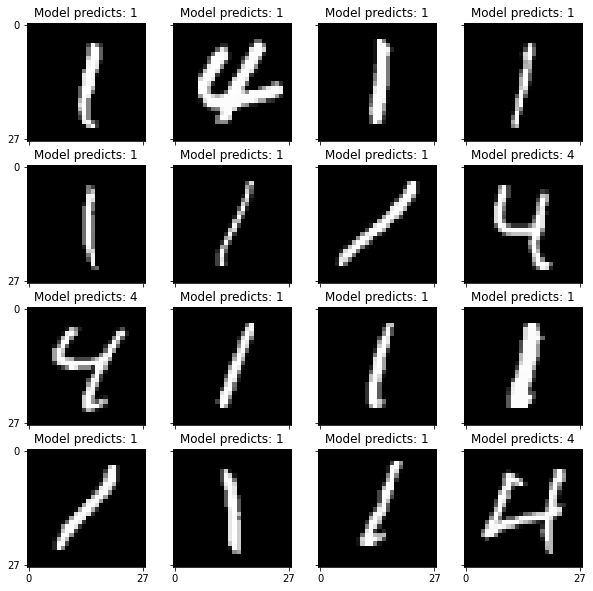

In [ ]:
mat_weights = vec_w_opt_lda.reshape(NRow, NCol)

num_grid = 4
fig, ax = plt.subplots(num_grid, num_grid, figsize=(10,10), subplot_kw=subplot_keywords, sharex=True, sharey=True)

# Take some random examples from the test dataset and show the prediction
train_images_digit_A_vec, train_images_digit_B_vec = matrix2vector(train_images_digit_A), matrix2vector(train_images_digit_B)
Test1, Test2, Test3 = train_images_digit_A_vec[:,3], train_images_digit_A_vec[:,600], train_images_digit_B_vec[:,600]

test_images_vec = matrix2vector(test_images)
for i in np.arange(num_grid):
    for j in np.arange(num_grid):
    # Take some random examples from the test dataset and show the prediction
        max_int = test_images_vec.shape[1]
        rand = np.random.randint(0, max_int)
        Example_data = test_images_vec[:,rand]
        prediction = predict_one_y(vec_w_opt_lda, Example_data, digit_A, digit_B)
        ax[i,j].imshow(Example_data.reshape(NRow, NCol))
        ax[i,j].set_title(f"Model predicts: {prediction}")
plt.show()

# Notes

In [28]:
# Nr. 1
# Use:
# images = images.reshape(images.shape[0], (images.shape[1] * images.shape[2]))
# images = images.transpose()

# Instead of this without tranpose
# images = images.reshape((images.shape[1] * images.shape[2]), images.shape[0]) 

# Explaination
images = np.array([[[1.1,1.2],[1.3,1.4]], [[2.1,2.2],[2.3,2.4]], [[3.1,3.2],[3.3,3.4]]])
print(images.shape) # --> Just like (N,28,28) as in mnist
print("Before Reshape\n", images, "\n")
images_correct = images.reshape(images.shape[0], (images.shape[1] * images.shape[2]))
images_correct = images_correct.transpose()
print("Correct Reshape: Each Column is one feature vector = one image", images_correct, "\n")

images_wrong = images.reshape((images.shape[1] * images.shape[2]), images.shape[0]) 
print("Wrong Reshape. The .reshape() fills up the new matrix row by row. But we want the images filled up column by column", images_wrong)

(3, 2, 2)
Before Reshape
 [[[1.1 1.2]
  [1.3 1.4]]

 [[2.1 2.2]
  [2.3 2.4]]

 [[3.1 3.2]
  [3.3 3.4]]] 

Correct Reshape: Each Column is one feature vector = one image [[1.1 2.1 3.1]
 [1.2 2.2 3.2]
 [1.3 2.3 3.3]
 [1.4 2.4 3.4]] 

Wrong Reshape. The .reshape() fills up the new matrix row by row. But we want the images filled up column by column [[1.1 1.2 1.3]
 [1.4 2.1 2.2]
 [2.3 2.4 3.1]
 [3.2 3.3 3.4]]


In [30]:
feature_vector = matrix2vector(images)

In [31]:
feature_vector[1:]


array([[1.1, 2.1, 3.1],
       [1.2, 2.2, 3.2],
       [1.3, 2.3, 3.3],
       [1.4, 2.4, 3.4]])